In [ ]:
# Copyright 2019 Ocean Exploration Trust & Ian Vaughn
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its contributors
#    may be used to endorse or promote products derived from this software
#    without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.


# Evaluating NA094's USBL data

We should take a look at whether navcook is working, and more importantly whether the transforms are working correctly.  To follow along on your own machine, you'll need the following packages in ubuntu 16.04:

## Setup & Imports

To start with, we'll need a working jupyter notebook, some really standard dependencies, and a working copy of NGcore.  Let's walk through getting that all setup now.

```
sudo apt install python3-pip
python3 -m pip install --upgrade # (run this twice)
python3 -m pip install jupyter # (not available in apt, I checked)
sudo apt install python3-numpy python3-pandas python3-pyproj
# To start:
jupyter notebook
```
Now you're ready to test your install by running the imports.  Matplotlib may complain about rebuilding the font cache.  Whatever.

In [1]:
%matplotlib notebook

from NGcore import NGdslog
from NGcore import NGtform
from NGcore import NGtime
import pandas as pd
import numpy as np
import pyproj
import math
import matplotlib.pyplot as plt

In [2]:
# Unit tests are cool-- let's run those too, just for luck.
from NGcore import NGtform_test
from NGcore import NGnmea_test

import unittest

suite = unittest.TestLoader().loadTestsFromModule(NGnmea_test)
suite.addTests(unittest.TestLoader().loadTestsFromModule(NGtform_test))
unittest.TextTestRunner(verbosity=1).run(suite)


...............................................................
----------------------------------------------------------------------
Ran 63 tests in 0.031s

OK


<unittest.runner.TextTestResult run=63 errors=0 failures=0>

## Loading Data

Now that we have everything setup, let's load some data.  We'll load it directly out of the raw dslog directory.  On my machine, that's `/data/NA094/usbl-2018/raw/datalog/`, but that's almost certainly different.  These values may need to be tweaked to find the data.

In [3]:
DATA_DIR='/data/NA094/usbl-2018/raw/datalog/'
DATA_VALIDATION_START_T='2018-06-08T01:40:00Z'
DATA_VALIDATION_END_T='2018-06-08T05:33:00Z'

start_t = NGtime.NGtimestamp.fromLog(DATA_VALIDATION_START_T)
end_t = NGtime.NGtimestamp.fromLog(DATA_VALIDATION_END_T)

print('Extracting all data from ', start_t.isoformat(), ' to ', end_t.isoformat())

# Load the USBL Data
d = []
usbl_parser = NGdslog.Usbl()
for obj in usbl_parser.parseDir(DATA_DIR, '*.USBL', startT=start_t, endT=end_t):
    d.append(obj)
usbl_frame = pd.DataFrame(d)

# Load the spsol high-rate seapath data
d = []
json_parser = NGdslog.Json()
for obj in json_parser.parseDir(DATA_DIR, '*.SPSOL', startT=start_t, endT=end_t):
    d.append(obj)
seapath_frame = pd.DataFrame(d)
    
# Load the navcook results
d_pv = []
d_m1 = []
d_m2 = []
d_m3 = []
nmea_parser = NGdslog.Nmea()
for obj in nmea_parser.parseDir(DATA_DIR, '*.NAV', startT=start_t, endT=end_t):
    if obj['msg'] == 'GGA':
        if obj['talker'] == 'PV':
            d_pv.append(obj)
        elif obj['talker'] == 'M1':
            d_m1.append(obj)
        elif obj['talker'] == 'M2':
            d_m2.append(obj)
        elif obj['talker'] == 'M3':
            d_m3.append(obj)
    
navcook_pv_frame = pd.DataFrame(d_pv)
navcook_m1_frame = pd.DataFrame(d_m1)
navcook_m2_frame = pd.DataFrame(d_m2)
navcook_m3_frame = pd.DataFrame(d_m3)

# Let's do some sanity checks....
print('\nFrame shapes:')
print('      USBL: ', usbl_frame.shape)
print('   Seapath: ', seapath_frame.shape)
print('Navcook/PV: ', navcook_pv_frame.shape)
print('Navcook/M1: ', navcook_m1_frame.shape)
print('Navcook/M2: ', navcook_m2_frame.shape)
print('Navcook/M3: ', navcook_m3_frame.shape)

print('\nFrame columns:')
print(usbl_frame.columns)
print(seapath_frame.columns)
print(navcook_m3_frame.columns)

Extracting all data from  2018-06-08T01:40:00  to  2018-06-08T05:33:00

Frame shapes:
      USBL:  (3839, 12)
   Seapath:  (69851, 21)
Navcook/PV:  (13943, 16)
Navcook/M1:  (0, 0)
Navcook/M2:  (0, 0)
Navcook/M3:  (3839, 16)

Frame columns:
Index(['bearing', 'dslog', 'reserved', 'sensor', 'slantRange', 'src', 'target',
       'time', 'timestr', 'x', 'y', 'z'],
      dtype='object')
Index(['calc_checksum', 'checksum', 'dslog', 'header', 'heading', 'heave',
       'height', 'json_time', 'latitude', 'longitude', 'pitch', 'rate_heading',
       'rate_pitch', 'rate_roll', 'roll', 'sensor', 'src', 'time', 'vel_down',
       'vel_east', 'vel_north'],
      dtype='object')
Index(['ant_alt_units', 'ant_geoid_alt', 'diff_station', 'dslog',
       'geoid_units', 'gps_t', 'idstr', 'lat', 'lon', 'msg', 'quality',
       'quality_str', 'sensor', 'src', 'talker', 'time'],
      dtype='object')


<IPython.core.display.Javascript object>


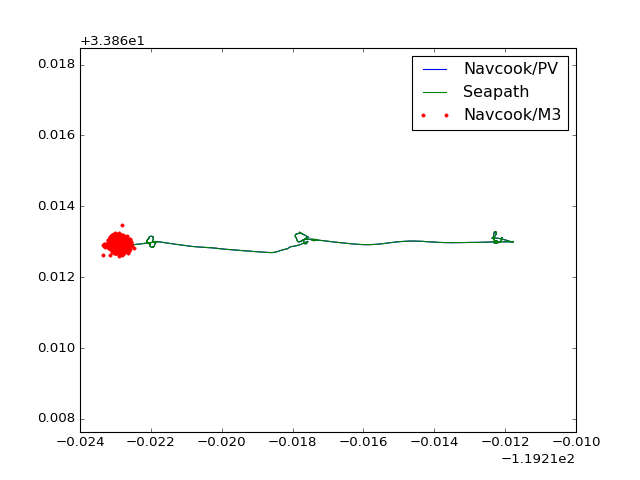

In [4]:
plt.plot(navcook_pv_frame['lon'], navcook_pv_frame['lat'])
plt.plot(seapath_frame['longitude'], seapath_frame['latitude'])
plt.plot(navcook_m3_frame['lon'], navcook_m3_frame['lat'], '.')
plt.legend(['Navcook/PV', 'Seapath', 'Navcook/M3'])
plt.axis('equal')
plt.show()

# Evaluating the Results

Great! Now that the data's loaded we can finally analyze the results.  This step is surprisingly difficult.  There are a few reasons for this.  First, navigation is surprisingly hard. You have to get N things right-- N-2 might look indistinguishable from N-20 and its really hard to guess N.  On top of that, there's a lot of noise that generally confuses things.  Some noise, like MRU-related issues, can be fixed.  Other noise, like angle estimation issues at the head, generally can't be fixed.  On top of that, sound velocity issues can easily introduce a bias that won't be corrected by improving the offset estimation.

Before we begin the analysis then, let's come up some criteria:
1. We'd like to see a small bias.  That means that as the ship moves and changes the geometry of the problem, we'd like to see errors that remain (approximately) Gaussian
2. We'd like to double-check the final noise-related errors and make sure the system isn't getting worse
Clearly, some sort of statistical analysis is required.

Let's start with what the manufacturer promises.  According to Tracklink's webpage (https://www.link-quest.com/html/models2.htm), Nautilus's TL5000MA should have accuracy of up to 1 degree.  Slant range accuracy is 0.3m, but angular error dominates directly under the ship where Hercules typically operates.  Based on this specification, the angular error contribution should be roughly 1.75% of slant range.

With a proper calibration and effective use of the Seapath-- a VRU far beyond what the TrackLink was ever expected to work with-- it has historically be possible to significantly exceed the state accuracy of the TrackLink.  Still, let's start with looking at the quoted accuracy.



In [5]:
accuracy_deg = 1.0
dep_avg = abs(np.mean(navcook_m3_frame['ant_geoid_alt']))
print('Accuracy: %.6f %%slant range' % (100*math.tan(math.radians(accuracy_deg))))
print('Accuracy (     below ship): %.1fm' % (dep_avg*math.tan(math.radians(accuracy_deg))))
print('Accuracy ( 100m from ship): %.1fm' % (math.sqrt(dep_avg**2 + 100**2)*math.tan(math.radians(accuracy_deg))))
print('Accuracy ( 500m from ship): %.1fm' % (math.sqrt(dep_avg**2 + 500**2)*math.tan(math.radians(accuracy_deg))))
print('Accuracy (1000m from ship): %.1fm' % (math.sqrt(dep_avg**2 + 1000**2)*math.tan(math.radians(accuracy_deg))))

Accuracy: 1.745506 %slant range
Accuracy (     below ship): 14.2m
Accuracy ( 100m from ship): 14.3m
Accuracy ( 500m from ship): 16.7m
Accuracy (1000m from ship): 22.5m


Centering projection on lat:33.872965378, lon:-119.232909317


<IPython.core.display.Javascript object>


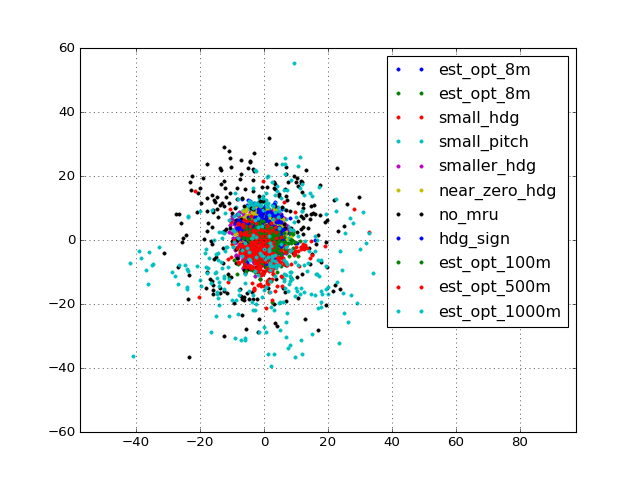

In [6]:
# Now let's plot all the tests.
d = {'start_time': ['2018-06-08T01:40:00Z','2018-06-08T01:53:30Z','2018-06-08T02:12:00Z','2018-06-08T02:43:30Z','2018-06-08T02:50:02Z','2018-06-08T03:13:45Z','2018-06-08T03:31:10Z','2018-06-08T03:46:35Z','2018-06-08T04:09:00Z','2018-06-08T04:42:00Z','2018-06-08T05:17:00Z'],
     'end_time': ['2018-06-08T01:53:00Z','2018-06-08T02:06:21Z','2018-06-08T02:25:10Z','2018-06-08T02:56:51Z','2018-06-08T03:13:00Z','2018-06-08T03:29:01Z','2018-06-08T03:45:42Z','2018-06-08T03:59:49Z','2018-06-08T04:24:00Z','2018-06-08T05:00:00Z','2018-06-08T05:33:00Z'],
     'name': ['est_opt_8m', 'est_opt_8m', 'small_hdg', 'small_pitch', 'smaller_hdg', 'near_zero_hdg', 'no_mru', 'hdg_sign', 'est_opt_100m', 'est_opt_500m', 'est_opt_1000m'],
    }
d['start_time'] = [NGtime.NGtimestamp.fromLog(x) for x in d['start_time']]
d['end_time'] = [NGtime.NGtimestamp.fromLog(x) for x in d['end_time']]
test_time_frame = pd.DataFrame(data=d)
# Everybody just HAS to have their own datetime format.  Yay.
test_time_frame['start_time'] = pd.to_datetime(test_time_frame['start_time'])
test_time_frame['end_time'] = pd.to_datetime(test_time_frame['end_time'])

# Before all this indexing, slicing, and analysis, let's go ahead and make our 
# own copy of the data.  You know, for luck and re-analysis and all that jazz.
m3 = navcook_m3_frame
m3['time'] = pd.to_datetime(m3['time'])
m3.set_index('time')

# We're going to want the resulting plot in meters because that's how humans 
# think about nav uncertainty (at least since the development of spaceflight, anyway)
# First though, we need an origin
avg_lat = np.mean(m3['lat'])
avg_lon = np.mean(m3['lon'])

# Great, now let's create a local transverse mercator projection centered on the average beacon position
localproj = pyproj.Proj('+proj=tmerc +lat_0=%.16f +lon_0=%.16f +ellps=WGS84 +datum=WGS84 +no_defs' % (avg_lat, avg_lon))
wgs84 = pyproj.Proj('+init=EPSG:4326') # we'll need a standard WGS84 projection too

print('Centering projection on lat:%.9f, lon:%.9f' % (avg_lat, avg_lon))

plt.figure()
# Great, so m3 is setup for convienent slicing.  Let's interate through each of the validation tests
for i in range(0,test_time_frame.shape[0]):
    test_mask = (m3['time'] >= test_time_frame.loc[i,'start_time']) & (m3['time'] <= test_time_frame.loc[i,'end_time'])
    test_data = m3.loc[test_mask]
    x,y = pyproj.transform(wgs84, localproj, test_data['lon'].tolist(), test_data['lat'].tolist())

    # Ok, test_data is now the same as m3, but ONLY refers to this specific test.
    #plt.plot(test_data['lon'], test_data['lat'], '.')
    plt.plot(x,y,'.')

plt.legend(test_time_frame['name'])
plt.axis('equal')
plt.grid(True)
plt.axis([-60,100,-60,60])
plt.show()




# Initial analysis

Initially, this may seem fine-- a ball of points roughly centered on 0.  Things get clearly worse as range increases-- no surprise there.  The nav solution is also made dramatically worse when the MRU is turned off, which neatly replicates previous results from 2015.  However, it looks like there's a bit of a bias in the "no_mru" data-- the points form a ring around the beacon rather than a more reasonable Gaussian distribution.  Turning the MRU off should increase random noise, not biases.  The MRU was off though, which might confuse things.  Let's look more closely at that first test with the estimated offsets with the ship spinning right over the beacon.

<IPython.core.display.Javascript object>


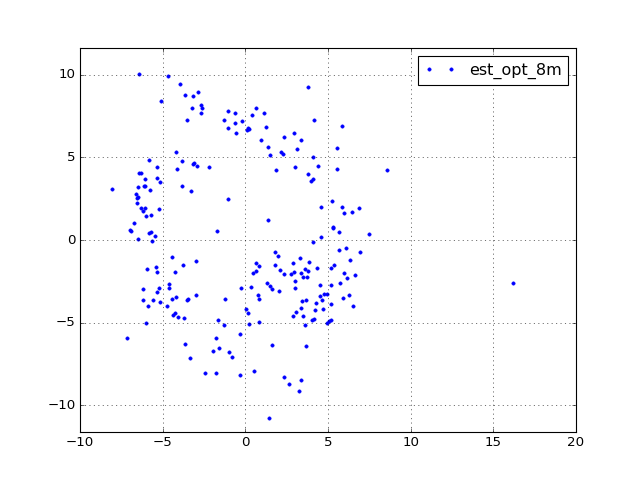

In [7]:
plt.figure()

# The desired test is the first one, so just grab that
idx=0
test_mask = (m3['time'] >= test_time_frame.loc[idx,'start_time']) & (m3['time'] <= test_time_frame.loc[idx,'end_time'])
test_data = m3.loc[test_mask]

avg_lat = np.mean(test_data['lat'])
avg_lon = np.mean(test_data['lon'])
localproj = pyproj.Proj('+proj=tmerc +lat_0=%.16f +lon_0=%.16f +ellps=WGS84 +datum=WGS84 +no_defs' % (avg_lat, avg_lon))

x,y = pyproj.transform(wgs84, localproj, test_data['lon'].tolist(), test_data['lat'].tolist())
plt.plot(x,y,'.')
plt.legend([test_time_frame.loc[idx,'name']])
plt.axis('equal')
plt.grid(True)
#plt.axis([-15,15,-15,15])
plt.show()

There's a few things to see here.  First, this is clearly a circle-- not the tight Gaussian-distributed ball we'd see if the primary error contribution was from random angle estimation error or uncorrected ship motion.  The Radius looks to be about 5m or so.  That's interesting.  A real analysis should probably include some statistics or something.  We're going to look at several things: the distribution of range errors, and the actual positioning accuracy.

We'll start by looking at an individual test-- this same one here-- and then compare statistics over a bunch of tests.

<IPython.core.display.Javascript object>


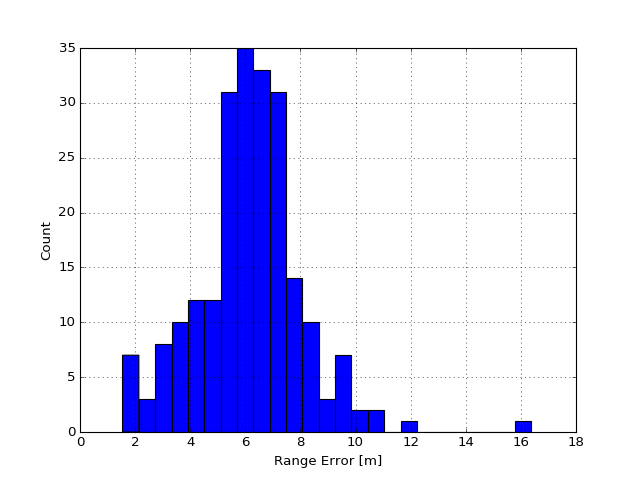

In [8]:
r = np.sqrt(np.square(np.array(x)) + np.square(np.array(y)))
cep = np.median(r)
r_mean = np.mean(r)
# CEP is defined as the error distance that half of the points are inside

plt.figure()
plt.hist(r, 25)
plt.grid(True)
plt.xlabel('Range Error [m]')
plt.ylabel('Count')
plt.show()


<IPython.core.display.Javascript object>


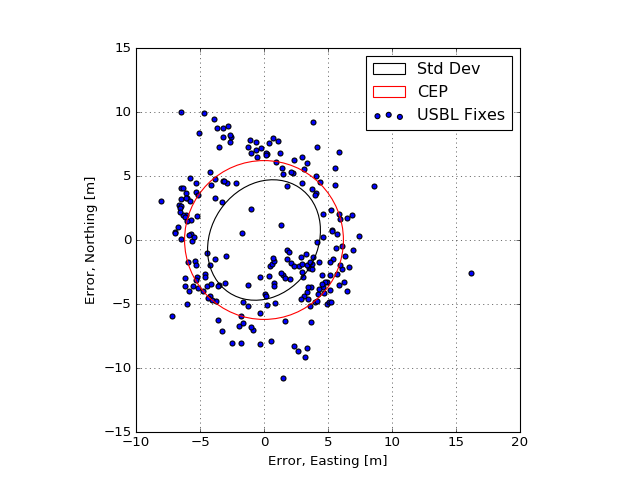

In [9]:
from matplotlib.patches import Ellipse, Circle

dat = np.array([x,y])
sigma = np.cov(dat)
evals, evecs = np.linalg.eig(sigma) # Do an eigenvector decomposition
sqrt_evals = np.sqrt(evals) # Get the square-root 

plt.figure()
ax = plt.subplot(111, aspect='equal')
ell = Ellipse(xy=(0,0), width=sqrt_evals[0]*2, height=sqrt_evals[1]*2, 
              angle=np.rad2deg(np.arccos(evecs[0,0])))
ell.set_facecolor('none')
ax.add_artist(ell)

circ = Circle(xy=(0,0), radius=cep)
circ.set_edgecolor('red')
circ.set_facecolor('none')
ax.add_artist(circ)

pts = plt.scatter(x,y)
plt.xlabel('Error, Easting [m]')
plt.ylabel('Error, Northing [m]')
plt.grid(True)
plt.legend([ell, circ, pts], ['Std Dev', 'CEP', 'USBL Fixes'])
plt.show()


In [10]:
print('Circular Error Probable (CEP): %.3f\n' % cep)
print('Rayleigh mean %.4f implies std. dev. %.4f\n' % (r_mean, r_mean*np.sqrt(2/np.pi)))
print('Actual standard deviation, major: %.4f m, minor: %.4f m' % (sqrt_evals[1], sqrt_evals[0]))

Circular Error Probable (CEP): 6.205

Rayleigh mean 6.1321 implies std. dev. 4.8927

Actual standard deviation, major: 4.9334 m, minor: 4.1527 m


## Single-Test analysis

### The Range Error Histogram

The first figure above shows a histogram of range errors.  Assuming the positioning errors are Gaussian and independent-- both highly questionable-- the histogram should follow a Rayleigh distribution (https://en.wikipedia.org/wiki/Rayleigh_distribution) with the mean of the range error distrubtion related to the scale parameter and thus the range error in the easting and northing.

Unfortunately, there are many ways of describing positioning error.  Scientists commonly use a 1-standard deviation bound.  Other common methods include 2-standard deviations, a 95% confidence interval, and Circular Error Probable (CEP).  CEP comes from ballistics, and is defined as "the radius of a circle centered on the mean, whose boundary is expected to include the landing points of 50%" of fixes (shamelessly stolen from: https://en.wikipedia.org/wiki/Circular_error_probable except that we care about fixes, not rounds).  It's easily computed as the median range error-- which is at least easy to get.  We'll use both CEP and standard deviation.

### A more complete 2D analysis

The full 2-D covariance matrix is computed above.  An eigenvalue decomposition is used to find the major and minor axes of the resulting 1-standard deviation ellipse-- or the long and short directions of the error ellipse, respectively.  This approach examines the error ellipse in terms of its empircally-relevant dimensions rather than the arbitrarily imposed coordinate frame discussed so far.  

Ideally the ellipse should be circular-- that it isn't suggests something else may be going on.

### What next?

Now that we've looked at how to analyze a single test, its time to re-run the evaluation over all the validation datasets and compare results.  Let's see how that goes.  We'll compare CEP to the major and minor axes of the 1-standard deviation error ellipse.


<IPython.core.display.Javascript object>


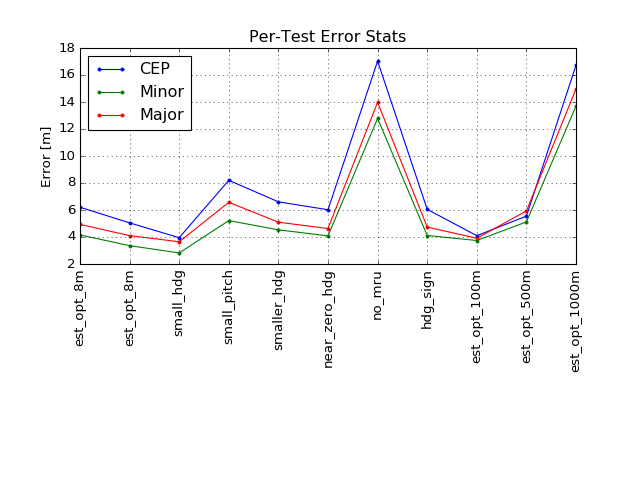

<IPython.core.display.Javascript object>


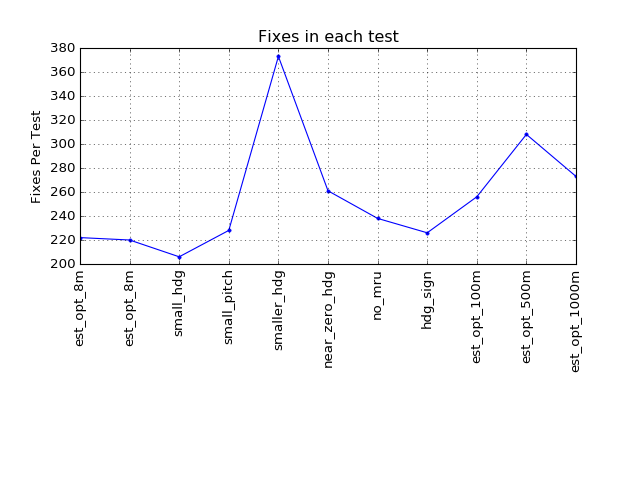

In [11]:
# First, setup our error stats
cep_vec = np.zeros((test_time_frame.shape[0]))
minor_vec = np.zeros((test_time_frame.shape[0]))
major_vec = np.zeros((test_time_frame.shape[0]))
count_vec = np.zeros((test_time_frame.shape[0]))

# We're going to interate through ALL the tests, just like we did before.
for i in range(0,test_time_frame.shape[0]):
    test_mask = (m3['time'] >= test_time_frame.loc[i,'start_time']) & (m3['time'] <= test_time_frame.loc[i,'end_time'])
    test_data = m3.loc[test_mask]
    x,y = pyproj.transform(wgs84, localproj, test_data['lon'].tolist(), test_data['lat'].tolist())
    
    # Subtract off the mean position to re-center
    xarr = np.array(x)
    yarr = np.array(y)
    xarr -= np.mean(xarr)
    yarr -= np.mean(yarr)
    
    r = np.sqrt(np.square(xarr) + np.square(yarr))
    dat = np.vstack((xarr, yarr))
    
    sigma = np.cov(dat)
    evals, evecs = np.linalg.eig(sigma) # Do an eigenvector decomposition
    sqrt_evals = np.sqrt(evals) # Get the square-root 
    
    cep_vec[i] = np.median(r)
    # Sadly, numpy doesn't sort its eigenvalues.  Because that would be helpful.
    minor_vec[i] = np.min(sqrt_evals)
    major_vec[i] = np.max(sqrt_evals)
    count_vec[i] = r.shape[0] 
    
fig, ax = plt.subplots()
plt.plot(cep_vec, '.-', label='CEP')
plt.plot(minor_vec, '.-', label='Minor')
plt.plot(major_vec, '.-', label='Major')
plt.ylabel('Error [m]')
plt.grid(True)
plt.legend(loc='upper left')
plt.xticks(range(0,test_time_frame.shape[0]), test_time_frame['name'], rotation='vertical')
fig.subplots_adjust(bottom=0.45) # Give a little extra space for labels
plt.title('Per-Test Error Stats')

fig, ax = plt.subplots()
plt.plot(count_vec, '.-')
plt.ylabel('Fixes Per Test')
plt.grid(True)
plt.xticks(range(0,test_time_frame.shape[0]), test_time_frame['name'], rotation='vertical')
fig.subplots_adjust(bottom=0.45) # Give a little extra space for labels
plt.title('Fixes in each test')

plt.show()

    
    

# Multi-Test Analysis & Conclusions

Results across each of the different tests are braodly consistent with expectations so far.  The No-MRU test shows a massive increase in error, as expected.  Similarly, tests at increasing ranges also produce significantly more error as range increases.  This two, is as expected.

The results at near-zero range remain alarming, and no solution in the data is forthcoming.  Although there appears to be a small reduction in error during the "small_heading" test, its on the order of the variation for the first two tests, suggesting something else may account for the difference.  Its always worth checking the number of points with each bin to see if we're looking at actual variation or just undersampling-- however, the test appears to include very consistent durations across the individual tests, making such effects unlikely.

Still, it doesn't take a Chi-squared test to see that there's a bias in the 8m datasets.  There are many possible sources of bias in the positioning data.  Further analysis is required that goes beyond simply digging into Navcook results.  That analysis will be broken out into a different file that references the same validation dataset but aggregated using the UsblCal Nautilus-specific data aggregation tools.



